# Quand la Prédiction Échoue

## Quand tout ce que vous avez est un marteau...

Entre 2015 et 2020, le machine learning a connu une montée en puissance massive. Son utilité prouvée dans les domaines de la vision par ordinateur et de la compréhension du langage naturel, combinée à un manque initial de professionnels dans ce domaine, a offert une opportunité parfaite pour une industrie de l'enseignement de le machine learning. Des figures comme Andrew Ng et Sebastian Thrun ont réussi à enseigner le machine learning au monde entier à des prix très bas. En parallèle, sur le plan logiciel, il est devenu de plus en plus facile d'ajuster un modèle de machine learning complexe (comme vous l'avez déjà vu avec les quelques lignes de code qu'il nous a fallu pour écrire un modèle d'IA dans le chapitre précédent). Des tutoriels sur la manière de créer des systèmes intelligents ont fleuri sur Internet. Le coût d'entrée en machine learning a chuté.

![img](./data/img/when-prediction-fails/ml-in-5.png)

Construire un modèle de machine learning est devenu si simple que vous n'avez même plus besoin de savoir coder très bien (et j'en suis la preuve vivante), ni de connaître les mathématiques derrière les algorithmes. En fait, vous pourriez accomplir des merveilles avec les 5 lignes de Python suivantes.

```python
X_train, y_train, X_test, y_test =  train_test_split(X, y)

## instancier le modèle de machine learning
model = MachineLearningModel()

## Ajuster le modèle de machine learning
model.fit(X_train, y_train)

# Faire des prédictions sur des données non vues
y_pred = model.predict(X_test)

# Évaluer la qualité des prédictions
print("Performance", metric(y_test, y_pred))
```

Dans l'ensemble, c'est une chose incroyable ! Je suis tout à fait favorable à la diffusion de contenu de valeur et à sa mise à disposition. Cependant, il y a aussi un côté sombre à tout cela. Cette nouvelle vague de data scientists a été formée principalement à la modélisation prédictive, car c'est ce que le machine learning cherche principalement à résoudre. En conséquence, chaque fois que ces data scientists rencontraient un problème commercial, ils tentaient de le résoudre, sans surprise, avec des modèles prédictifs. Lorsqu'il s'agissait effectivement de problèmes de prédiction, comme celui que nous avons vu dans le chapitre précédent, le data scientist réussissait généralement et tout le monde était heureux. Cependant, il existe toute une classe de problèmes qui ne sont tout simplement pas solvables avec des techniques de prédiction. Et lorsque ces problèmes se présentaient, les data scientists échouaient généralement lamentablement. Ce sont des problèmes formulés de la manière suivante : "de combien puis-je augmenter Y en changeant X ?"

D'après mon expérience, ce type de problème est généralement ce qui intéresse le plus la direction. Ils veulent souvent savoir comment augmenter les ventes, réduire les coûts ou attirer plus de clients. Inutile de dire qu'ils ne sont pas très heureux lorsqu'un data scientist leur donne une réponse sur la manière de prédire les ventes au lieu de leur expliquer comment les augmenter. Malheureusement, lorsque tout ce que le data scientist connaît, ce sont les modèles prédictifs, cela a tendance à se produire fréquemment. Comme un de mes anciens patrons me l'a dit un jour : "quand tout ce que vous avez est un marteau, tout commence à ressembler à un clou."

Comme je l'ai dit, je suis tout à fait favorable à la réduction du coût de l'accès au savoir, mais le programme actuel de formation des data scientists présente une énorme lacune. Je pense que mon rôle ici est de combler cette lacune. Mon objectif est de vous équiper d'outils pour résoudre cette autre classe de problèmes, qui sont de nature causale.

Ce que vous essayez de faire, c'est d'estimer comment quelque chose que vous pouvez contrôler (publicité, prix, service client) affecte ou cause quelque chose que vous souhaitez changer, mais que vous ne pouvez pas contrôler directement (ventes, nombre de clients, PNL). Mais avant de vous montrer comment résoudre ces problèmes, je veux vous montrer ce qui se passe lorsque vous les traitez comme des tâches de prédiction et essayez de les résoudre avec la boîte à outils traditionnelle de le machine learning. La raison en est que les data scientists viennent souvent me voir en disant : "OK, bien que traiter des problèmes causaux avec des outils de prédiction ne soit pas l'idée la plus judicieuse, cela doit quand même aider un peu, non ? Je veux dire, ça ne peut pas faire de mal...". Eh bien, il se trouve que cela peut faire mal. Et il vaut mieux comprendre cela avant de commencer à marteler votre propre pouce.

![img](./data/img/when-prediction-fails/horse-meme.png)

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

# helper functions for this notebook
from nb18 import ltv_with_coupons

## Qui Veut un Coupon ?

Pour rendre les choses plus concrètes, continuons avec l'exemple que nous avons utilisé dans le chapitre précédent, mais avec un petit changement. Avant, nous essayions de distinguer les clients rentables des non rentables. Nous avons formulé cela comme un problème de prédiction : prédire la rentabilité des clients. Nous pouvions alors construire un modèle de machine learning pour cette tâche et l'utiliser pour choisir avec qui nous ferions affaire : uniquement les clients que nous prédirions comme rentables. En d'autres termes, notre objectif était de séparer les clients rentables des non rentables, ce que nous pouvions faire avec un modèle prédictif.

Maintenant, vous avez une nouvelle tâche. Vous soupçonnez que donner des coupons aux nouveaux clients augmente leur engagement avec votre entreprise et les rend plus rentables à long terme. Autrement dit, ils dépensent plus et sur une plus longue période. Votre nouvelle mission est de déterminer quelle devrait être la valeur du coupon (y compris zéro). Remarquez qu'avec les coupons, vous donnez essentiellement de l'argent aux gens pour qu'ils dépensent dans votre entreprise. Pour cette raison, ils apparaissent comme un coût dans votre comptabilité. Notez que si la valeur du coupon est trop élevée, vous perdrez probablement de l'argent, car les clients achèteront tout ce dont ils ont besoin en utilisant uniquement les coupons. C'est une autre manière de dire qu'ils obtiendront votre produit gratuitement. À l'inverse, si la valeur du coupon est trop faible (ou nulle), vous ne distribuez même pas de coupons. Cela pourrait être une réponse valable, mais il se peut aussi qu'une réduction initiale, sous forme de coupons, soit plus rentable à long terme.

Pour des raisons que vous verrez plus tard, nous utiliserons une fonction de génération de données au lieu de charger un ensemble de données statiques. La fonction `ltv_with_coupons` génère des données de transaction pour nous. Comme vous pouvez le voir, elles ont le même format que celui que nous avons vu précédemment, avec une ligne par client, une colonne pour le coût d'acquisition et des colonnes pour les transactions entre le jour 1 et le jour 30.

In [2]:
transactions, customer_features = ltv_with_coupons()

print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,5,0,2,2,...,0,3,0,4,0,0,0,0,0,0
1,1,-61,2,0,5,2,3,4,1,0,...,5,0,1,35,11,0,5,2,4,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


Quant aux autres parties des données, encore une fois, nous avons un identifiant de client, la région où le client réside, le revenu du client et l'âge du client. De plus, nous avons maintenant une variable appelée `coupons`, qui nous indique combien nous avons donné en coupons à ce client.

In [3]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,coupons,age
0,0,18,1025,5,24
1,1,40,1649,5,26
2,2,35,2034,15,33
3,3,29,1859,15,35
4,4,11,1243,5,26


Pour traiter ces données dans un seul dataframe, nous allons additionner toutes les colonnes du premier tableau (c'est-à-dire en additionnant `CACQ` avec les transactions). Cela nous donnera la valeur nette `net_value`, comme cela a été calculé dans le chapitre précédent. Ensuite, nous ajouterons les données des caractéristiques et mettrons à jour la `net_value` pour inclure le coût des coupons.

In [4]:
def process_data(transactions, customer_data):

    profitable = (transactions[["customer_id"]]
                  .assign(net_value = transactions
                          .drop(columns="customer_id")
                          .sum(axis=1)))

    return (customer_data
            # join net_value and features
            .merge(profitable, on="customer_id")
            # include the coupons cost
            .assign(net_value = lambda d: d["net_value"] - d["coupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,15,33,-23
3,3,29,1859,15,35,-45
4,4,11,1243,5,26,-26


Ce dataframe traité contient tout ce dont nous avons besoin. Il contient notre variable cible `net_value`, il contient les caractéristiques des clients `region`, `income` et `age`, et il contient le levier ou traitement que nous voulons optimiser : les coupons. Pour commencer à comprendre comment les coupons peuvent augmenter la `net_value`, examinons comment ils ont été distribués.

In [5]:
customer_features.groupby("coupons")["customer_id"].count()

coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

Nous pouvons voir que la plupart des coupons distribués avaient une valeur de 5 BRL, suivis des coupons d'une valeur de 10 BRL. Nous avons distribué très peu de coupons de 15 BRL ou aucun coupon (valeur nulle). Cela indique qu'ils n'ont **PAS** été distribués de manière aléatoire. Pour vérifier cela, voyons la corrélation entre les autres variables et les coupons.

In [6]:
customer_features.corr()[["coupons"]]

,coupons
customer_id,0.002239
region,-0.004073
income,0.001236
coupons,1.000000
age,0.897308
net_value,-0.078369


C'est intéressant. Il semble que plus la personne est âgée, plus la probabilité qu'elle reçoive un coupon est élevée. Cela indique un certain biais dans nos données. Nous pouvons également observer une corrélation négative entre les coupons et la `valeur_nette` : plus nous distribuons de coupons, plus la `valeur_nette` est faible. Cela ne semble pas être un lien de causalité, car nous savons déjà que les coupons n'ont pas été distribués de manière aléatoire. Il se pourrait, par exemple, que les personnes âgées dépensent moins pour nos produits et reçoivent également des coupons de plus grande valeur, ce qui fausse la relation entre les coupons et la `valeur_nette` au point de la rendre négative.

Le point ici est que nous savons qu'il y a un biais. Cependant, comme ce chapitre est déjà bien chargé, je vais l'ignorer pour l'instant (en fait, je vais contourner le problème avec un artifice que vous verrez dans un instant). Gardez simplement à l'esprit que c'est quelque chose que nous devrons aborder à un moment donné.

À ce stade de l'analyse, **si c'était un problème de prédiction**, nous diviserions probablement l'ensemble de données en un ensemble d'entraînement et un ensemble de test pour construire et évaluer des politiques respectivement. Mais ce n'est PAS un problème de prédiction. L'objectif final ici n'est pas d'obtenir une bonne prédiction de la rentabilité des clients. Au lieu de cela, il s'agit de déterminer la meilleure stratégie de distribution de coupons. Pour évaluer cette optimisation, nous devrions savoir comment les choses se seraient déroulées si nous avions distribué des coupons différents de ceux qui ont été réellement donnés. C'est le genre de question contrefactuelle "et si" que nous avons étudiée dans le cadre de la causalité. La validation croisée ne nous aidera pas ici, car nous ne pouvons tout simplement pas observer les contrefactuels. Nous ne pouvons voir que ce qui s'est passé pour les coupons qui ont effectivement été donnés, mais nous ne pouvons pas savoir ce qui se serait passé si les clients avaient reçu une autre valeur de coupon. Sauf si nous avons des données simulées !

Si nos données sont simulées, nous pouvons générer exactement les mêmes données, en ne changeant que les paramètres de la valeur des coupons. Cela nous permettra de voir comment la `valeur_nette` change en fonction des différentes stratégies de distribution de coupons. Nous serons alors en mesure de calculer l'effet du traitement entre différentes stratégies $ValeurNette_{t=a} - ValeurNette_{t=b}$. Avec la puissance des données simulées, comprendre ce chapitre sera beaucoup plus facile. Ah oui, et cela rendra également le problème de biais sans importance, car nous observerons directement l'effet causal.

Néanmoins, rappelez-vous toujours qu'il s'agit d'un artifice pédagogique. Dans le monde réel, vous n'avez pas de données simulées et vous ne pouvez certainement pas voir ce qui se serait passé avec différentes stratégies de traitement. Les effets causals individuels restent cachés, comme ils l'ont toujours été. Cela pose un problème intéressant. Comment pouvons-nous évaluer nos stratégies pour identifier l'effet causal si nous ne pouvons jamais voir l'effet causal réel ? La vraie réponse est très complexe et tellement importante qu'elle mérite son propre chapitre. Rassurez-vous, nous aborderons ce sujet. Pour l'instant, profitez simplement de la simplicité des données simulées. Et en parlant de simplicité...

## Politique Simple

Comme toujours, la première chose à faire lorsque nous rencontrons un nouveau problème de données est de nous demander : "Quelle est la chose la plus simple que je puisse faire qui apportera déjà de la valeur ?". Dans ce cas précis, la chose la plus simple est de revenir aux données dont nous disposons et d'estimer la `valeur_nette` pour chaque valeur de coupon. Ensuite, vérifiez quelle valeur de coupon génère la `valeur_nette` la plus élevée et donnez uniquement cette valeur de coupon à chaque client.

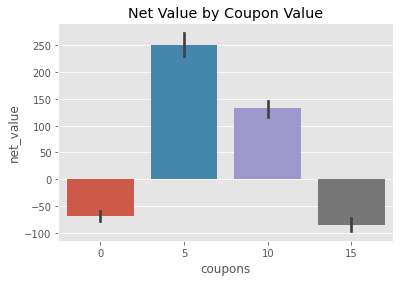

In [7]:
sns.barplot(data=customer_features, x="coupons", y="net_value")
plt.title("Net Value by Coupon Value");

En effectuant cette analyse, nous pouvons constater qu'en moyenne, nous perdons de l'argent lorsque la valeur du coupon est de 0 ou 15 BRL, et nous gagnons de l'argent pour les coupons de 5 et 10 BRL. La `valeur_nette` moyenne la plus élevée apparaît lorsque nous avons des coupons de 5 BRL, ce qui nous rapporte environ 250 BRL de `valeur_nette` par client. Naturellement, la chose la plus simple à essayer est donc de donner à tout le monde un coupon de 5 BRL et de voir comment cela se déroule. Cela ignore complètement la possibilité de biais, mais bon, nous parlons ici de simplicité !

Pour évaluer cette politique, la fonction `ltv_with_coupons` accepte en argument un tableau de 10 000 éléments qui contient le coupon souhaité pour chacun des 10 000 clients de notre base de données. Pour créer ce tableau, nous allons générer un tableau de 1 avec `np.ones` de la taille de notre tableau `coupons` (10 000) et le multiplier par 5. Ensuite, nous passerons ce tableau à la fonction `ltv_with_coupons`. Cela générera un nouvel ensemble de données exactement comme celui que nous avions précédemment, mais avec toutes les valeurs de coupons fixées à 5. Nous traiterons ensuite ces données pour obtenir la valeur nette selon cette nouvelle politique proposée.

In [8]:
simple_policy = 5 * np.ones(customer_features["coupons"].shape)

transactions_simple_policy, customer_features_simple_policy = ltv_with_coupons(simple_policy)
customer_features_simple_policy = process_data(transactions_simple_policy, customer_features_simple_policy)

customer_features_simple_policy.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,5,33,63
3,3,29,1859,5,35,63
4,4,11,1243,5,26,-26


Par précaution, vérifions si les caractéristiques sont bien inchangées, en tenant compte des premiers clients. Prenons le troisième, par exemple (`customer_id` 2). Pour ce client, la région est 35, le revenu est de 2034 et l'âge est de 33 ans. Si nous faisons défiler un peu plus haut, nous pouvons voir que cela correspond à ce que nous avions auparavant, donc tout est en ordre ici. Nous pouvons également vérifier que tous les coupons sont bien de 5 BRL. Enfin, la `valeur_nette` change comme prévu. L'une des raisons à cela est que le coût associé aux coupons va changer. Par exemple, ce client avait 15 BRL en coupons, mais maintenant c'est 5 BRL. Cela réduirait le coût de 15 à 5 unités. Mais remarquez que la `valeur_nette` passe de -23 à 63, soit une augmentation de 86 BRL de la `valeur_nette`. C'est bien plus que la différence de coût de 10. Ici, donner moins en coupons a rendu ce client particulier beaucoup plus rentable qu'il ne l'était auparavant. Enfin, pour évaluer la politique, nous pouvons simplement prendre la moyenne de la `valeur_nette`.

In [9]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

252.9268

Comme nous pouvons le voir, cette politique simple nous indique que nous pouvons obtenir, en moyenne, 253 BRL par client si nous leur donnons tous un coupon de 5 BRL. C'est énorme ! Mais pouvons-nous faire mieux ? Et si nous utilisions notre brillant outil de machine learning pour résoudre ce problème ? Essayons cela ensuite.

## Politique Basée sur un Modèle

Pour utiliser le machine learning, nous allons adapter ce que nous avons fait dans le chapitre précédent. L'idée est de construire un modèle de machine learning qui prédit la `valeur_nette`, comme précédemment, de prendre ces prédictions et de les regrouper en un certain nombre de classes définies. Ensuite, nous partitionnerons les données en ces classes. Essentiellement, nous divisons les clients en fonction de leur `valeur_nette` prédite. Les clients dont nous pensons qu'ils généreront à peu près la même `valeur_nette` se retrouveront dans la même classe ou groupe. Enfin, pour chaque groupe, nous verrons quelle valeur de coupon donne la `valeur_nette` maximale. Nous faisons la même chose que dans la politique simple, mais maintenant au sein des groupes définis par une classe de prédiction.

![img](./data/img/when-prediction-fails/partitions.png)

L'intuition derrière cela est la suivante : nous savons qu'en moyenne, les coupons de 5 BRL ont mieux performé. Cependant, il est possible que pour certains groupes de clients, une autre valeur soit encore meilleure que 5 BRL. Peut-être que 5 BRL est la stratégie optimale pour la plupart des clients, mais pas pour tous.

![img](./data/img/when-prediction-fails/personalise.png)

Si nous pouvons identifier ceux pour lesquels la valeur optimale est différente, nous pouvons élaborer une stratégie de distribution de coupons meilleure que celle que nous avons appliquée précédemment.

C'est ce que nous appelons un problème de personnalisation. Nous pouvons exploiter la personnalisation lorsque nous avons plus d'une stratégie à choisir et qu'au moins l'une d'entre elles n'est pas la meilleure stratégie globale, mais qu'elle est la meilleure pour un sous-ensemble de la population ciblée. Cette définition est un peu complexe, mais l'intuition est simple. Si vous n'avez qu'une seule stratégie, vous ne personnalisez pas. Vous faites la même chose pour chaque client. Si vous avez plus d'une stratégie, mais qu'une d'entre elles est meilleure pour chaque client, pourquoi personnaliser ? Vous pourriez simplement appliquer la meilleure stratégie. Vous ne ferez de la personnalisation que si une stratégie fonctionne mieux pour un sous-ensemble de la population et qu'une autre stratégie fonctionne mieux pour un autre sous-ensemble de la population.

Mais revenons à l'exemple. La première chose dont nous avons besoin est une fonction qui ajuste notre modèle prédictif et divise également les prédictions en classes de prédiction. Cette fonction renverra une autre fonction, une fonction de prédiction qui prendra un dataframe et ajoutera des colonnes de prédictions et de classes.

In [10]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    # train the ML model
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    # fit the bands
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict(test_set):
        # make predictions with trained model
        predictions = reg.predict(test_set[features])
        
        # discretize predictions into bands.
        pred_bands = np.digitize(predictions, bands, right=False) 
        return test_set.assign(predictions=predictions,
                               # cliping avoid creating new upper bands
                               pred_bands=np.clip(pred_bands, 1, n_bands))
    
    return predict

Pour évaluer la qualité de nos prédictions, nous diviserons l'ensemble de données en un ensemble d'entraînement et un ensemble de test. Remarquez ici que nous évaluons la qualité de la prédiction, PAS de la politique. C'est juste pour voir si notre modèle est bon dans ce qu'il est censé faire.

In [11]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

Maintenant, entraînons notre modèle et créons 10 classes avec ses prédictions.

In [12]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(1)
model = model_bands(train, features, target, model_params, n_bands=10)

Après avoir entraîné notre modèle, nous pouvons l'utiliser pour faire des prédictions en lui passant un dataframe. Le résultat sera également un dataframe avec 2 nouvelles colonnes : `predictions` et `pred_bands`.

In [13]:
model(train).head()

,customer_id,region,income,coupons,age,net_value,predictions,pred_bands
2228,2228,30,567,5,27,-129,-16.296297,2
5910,5910,32,647,5,25,-55,-16.296297,2
1950,1950,31,2953,15,33,-142,102.237797,7
2119,2119,1,2860,5,27,-23,94.291197,7
5947,5947,49,589,5,26,-91,-3.525593,3


Pour voir la puissance prédictive de notre modèle, nous pouvons examiner le $R^2$ pour les ensembles d'entraînement et de test.

In [14]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.5382953634651921
Test Score:,  0.504563847410434


Rappelez-vous que cette performance n'est que la performance prédictive. Ce que nous voulons vraiment savoir, c'est si ce modèle peut nous faire gagner de l'argent. Faisons une politique ! L'idée ici est très similaire à ce que nous avons vu dans le chapitre précédent. Nous regrouperons les clients par classe de prédiction. Ensuite, pour chaque type de client (où le type est défini par les classes), nous verrons quelle décision - la valeur du coupon dans notre cas - est la meilleure. Pour ce faire, nous pouvons regrouper nos données par classe de prédiction et valeur du coupon et tracer la `valeur_nette`.

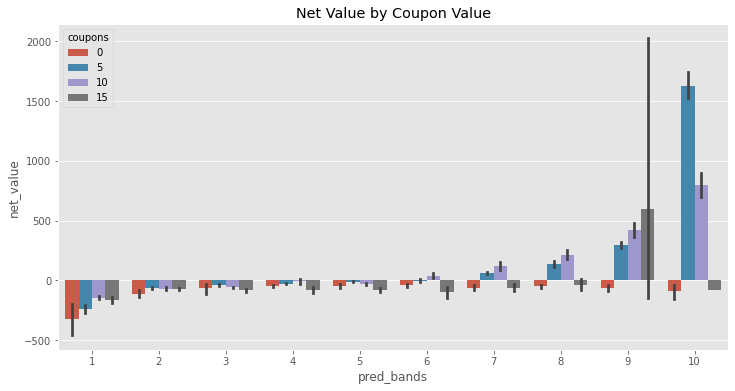

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(customer_features), x="pred_bands", y="net_value", hue="coupons")
plt.title("Net Value by Coupon Value");

Ce graphique est très intéressant. Remarquez comment la décision optimale change en fonction des classes de prédiction. Par exemple, dans les classes comme 1, 7 et 8, la meilleure chose à faire est de donner un coupon de 10 BRL. Pour les classes comme 3, 5 et 10, la meilleure chose est un coupon de 5 BRL. Cela signifie que cette politique est très similaire à celle simple, sauf pour la dernière classe. Cela indique que la personnalisation pourrait être possible, car la décision optimale change selon les sous-populations.

Nous pouvons coder cette politique avec quelques déclarations `if ... then ...`, mais je vais montrer une approche plus générale qui exploite les opérations sur les dataframes.

![img](./data/img/when-prediction-fails/pandas-magic.png)

Tout d'abord, nous regrouperons nos clients par classe et valeur du coupon et prendrons la `valeur_nette` moyenne pour chaque groupe, un peu comme dans le graphique ci-dessus.

In [16]:
pred_bands = (model(customer_features)
              .groupby(["pred_bands", "coupons"])
              [["net_value"]].mean()
              .reset_index())

pred_bands.head(7)

,pred_bands,coupons,net_value
0,1,0,-324.538462
1,1,5,-237.683871
2,1,10,-142.203390
3,1,15,-160.413223
4,2,0,-108.980769
5,2,5,-63.718650
6,2,10,-68.327146


Ensuite, nous regrouperons par classe et prendrons le rang de la `valeur_nette` pour chaque ligne. Cela ordonnera les lignes en fonction de la `valeur_nette` moyenne, où 1 est la meilleure `valeur_nette` dans cette classe.

In [17]:
pred_bands["max_net"] = (pred_bands
                         .groupby(['pred_bands'])
                         [["net_value"]]
                         .rank(ascending=False))


pred_bands.head(7)

,pred_bands,coupons,net_value,max_net
0,1,0,-324.538462,4.0
1,1,5,-237.683871,3.0
2,1,10,-142.203390,1.0
3,1,15,-160.413223,2.0
4,2,0,-108.980769,4.0
5,2,5,-63.718650,1.0
6,2,10,-68.327146,2.0


Par exemple, pour la classe 1, la meilleure stratégie de coupon est 10 BRL. Ensuite, nous ne garderons que la plus grande `valeur_nette` par classe.

In [18]:
best_coupons_per_band = pred_bands.query("max_net==1")[["pred_bands", "coupons"]]

best_coupons_per_band

,pred_bands,coupons
2,1,10
5,2,5
9,3,5
14,4,10
17,5,5
22,6,10
26,7,10
30,8,10
35,9,15
37,10,5


Pour construire notre politique, nous prendrons cette petite table ci-dessus et la rejoindrons à la table d'origine en utilisant la classe comme clé. Cela associera chaque ligne du tableau d'origine avec ce que nous pensons être la meilleure valeur de coupon, selon cette politique. Ensuite, nous trierons les lignes en fonction de l'`id_client` afin de conserver le même ordre que celui que nous avions précédemment. C'est important pour l'évaluation, car `ltv_with_coupons` prend en argument la valeur du coupon dans l'ordre du dataframe d'origine.

In [19]:
coupons_per_id = (model(customer_features)
                 .drop(columns=["coupons"])
                 .merge(best_coupons_per_band, on="pred_bands")
                 [["customer_id", "coupons"]]
                 .sort_values('customer_id'))

coupons_per_id.head()

,customer_id,coupons
0,0,10
1,1,10
788,2,5
1982,3,10
2743,4,5


Enfin, pour évaluer la politique, nous passons la colonne `coupons` comme tableau de coupons à la fonction `ltv_with_coupons`. Cela régénérera les données, maintenant en supposant que les coupons ont été donnés comme nous l'avons défini dans cette politique.

In [20]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_coupons(
    coupons_per_id[["coupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model, customer_features_policy_w_model)

customer_features_policy_w_model.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,10,24,-87
1,1,40,1649,10,26,42
2,2,35,2034,5,33,63
3,3,29,1859,10,35,-40
4,4,11,1243,5,26,-26


Encore une fois, vérifions par précaution : nous pouvons voir que le troisième client est toujours celui de la région 35, avec un revenu de 2034 et un âge de 33 ans. Il a également une valeur de coupon  de 5 BRL, tout comme nous l'avons établi dans notre politique.

Pour vérifier combien cette politique nous rapporte, nous pouvons calculer la moyenne de la `valeur_nette` pour ce nouvel ensemble de données.

In [21]:
policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

229.9341

Pas mal ! Nous pouvons espérer obtenir environ 230 BRL par client avec cette politique basée sur un modèle. Mais attendez une seconde ! Vous vous souvenez combien nous gagnions avec la politique simple ? Comparons-les côte à côte.

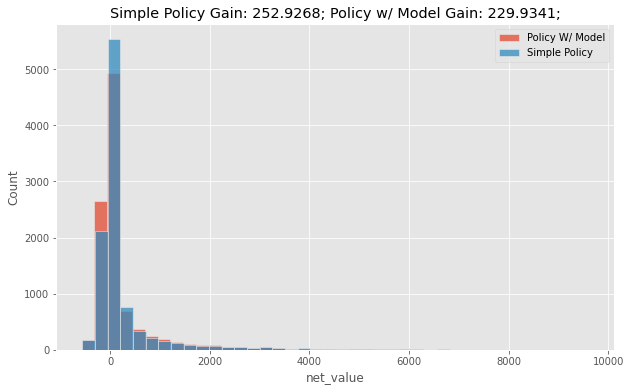

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer_features_policy_w_model, bins=40,
             x="net_value", label="Policy W/ Model", color="C0")
sns.histplot(data=customer_features_simple_policy, bins=40,
             x="net_value", label="Simple Policy", color="C1")
plt.legend()
plt.title(f"Simple Policy Gain: {simple_policy_gain}; Policy w/ Model Gain: {policy_w_model_gain};");

Voici où la plupart des Data Scientists tombent de leur chaise. La politique basée sur le modèle a une `valeur_nette` moyenne qui est de 20 BRL inférieure à celle d'une politique très simple. Comment un modèle qui est bon pour prédire la `valeur_nette` ne peut-il pas être bon pour une stratégie visant à maximiser la `valeur_nette` ? Il doit sûrement y avoir un bug dans le code. Vous vous trompez clairement. Cela ne peut pas être ! Eh bien, il se trouve qu'il y a une explication parfaitement raisonnable et simple à cela. Cependant, la réponse à cette question est si importante qu'elle mérite d'être explorée plus en profondeur.

## Se Frapper le Pouce avec des Prédictions

La réponse courte réside dans la compréhension de ce que nous voulons avec cette politique, à savoir optimiser la `valeur_nette` en jouant avec les valeurs des coupons. Si nous devions l'illustrer, il n'est pas insensé de penser que la `valeur_nette` aura une forme quadratique par rapport aux coupons : à mesure que nous augmentons la valeur du coupon, la `valeur_nette` augmente d'abord, puis atteint un point maximum. Après cela, toute valeur supplémentaire du coupon coûtera plus cher que ce qu'elle rapporte.

![img](./data/img/when-prediction-fails/opt-deriv.png)

Trouver la valeur optimale du coupon revient donc à trouver le maximum de la fonction `valeur_nette`. Nous pouvons le faire en différenciant la fonction et en la mettant à zéro (deuxième graphique). Les économistes pourraient reconnaître cela comme un problème de tarification. La manière dont ils (nous) aborderaient ce problème consisterait à supposer une forme fonctionnelle pour `valeur_nette`, à la différencier et à l'optimiser.

Cette approche présente de grands mérites, mais je pense qu'elle n'est pas si générale et qu'elle nécessite beaucoup de suppositions. Malheureusement, les données du monde réel ne sont pas accompagnées d'une fonction sous-jacente que nous pouvons différencier, donc des conjectures sont souvent nécessaires ici. Une approche plus pratique (et peut-être moins élégante) consiste à tester plusieurs valeurs de coupon et à voir laquelle donne la meilleure `valeur_nette`. C'est exactement ce que fait notre politique simple. Elle regarde ce qui s'est passé dans le passé et répète le traitement qui s'est avéré le plus prometteur.

En revanche, la politique basée sur le modèle procède différemment. Tout d'abord, la politique basée sur le modèle ajuste un modèle de machine learning pour prédire la `valeur_nette`. Ensuite, elle partitionne l'espace client en fonction des prédictions. Si le modèle est bon, cela revient à partitionner l'espace par `valeur_nette` elle-même, comme dans le graphique suivant.

![img](./data/img/when-prediction-fails/model-opt.png)

Plus la prédiction est précise, plus cette partition de l'espace se rapproche de la partition de la variable cible, `valeur_nette`. Faites très attention à ce qui se passe lorsque vous faites cela. Essentiellement, vous divisez les clients en ensembles où la `valeur_nette`, la chose que vous avez prédite, ne change pas ! Et cela a tout son sens d'un point de vue prédictif. Si votre modèle est bon en prédiction, des groupes de points ayant la même prédiction auront également la même `valeur_nette`.

Jusqu'ici, tout va bien, mais regardez ce que cela fait à la fonction perçue de `valeur_nette` par rapport aux coupons (lignes vertes). Cela les aplatit pour qu'elles n'aient plus de pente du tout. D'un point de vue prédictif, c'est formidable. Cela signifie que votre modèle a capturé toute la variation de la `valeur_nette`. Cependant, du point de vue de la politique, c'est terrible, car il ne reste plus de variance dans la `valeur_nette` pour voir comment elle changerait avec différentes valeurs de coupon. Sans cette variation dans la `valeur_nette`, il semblerait que changer les valeurs de coupon n'ait aucun effet sur la `valeur_nette`, nous laissant sans possibilité d'optimisation. D'ailleurs, il s'agit d'un phénomène général qui n'a rien à voir avec la forme quadratique spécifique que nous utilisons ici. Je ne fais qu'utiliser un exemple pour rendre les choses plus concrètes.

![img](./data/img/when-prediction-fails/flat-curves.png)

Pour résumer, chaque fois que nous voulons optimiser une variable $Y$ en utilisant une variable $T$, prédire $Y$ non seulement n'aidera pas, mais nuira à notre politique, car les partitions de données définies par la prédiction auront une variance $Y$ limitée, ce qui entravera notre capacité à estimer comment $T$ modifie $Y$, c'est-à-dire l'élasticité $\frac{\delta Y}{\delta T}$. C'est le paragraphe le plus important de ce chapitre. Tout est résumé ici, alors relisez-le si vous ne l'avez pas compris dès le début.

La clé pour corriger cette erreur réside dans l'ajustement de notre objectif à ce que nous voulons vraiment. Au lieu d'estimer $Y$ à partir de $X$, ce que fait la prédiction, nous devons estimer $\frac{\delta Y}{\delta T}$ à partir de $X$. Plus facile à dire qu'à faire. Comme vous l'avez peut-être déjà deviné, c'est précisément ce que l'inférence causale cherche à accomplir. Et, comme c'est naturel pour les problèmes causaux, nous ne pouvons pas observer notre quantité d'intérêt, $\frac{\delta Y}{\delta T}$. Vous ne pouvez tout simplement pas observer comment la `valeur_nette` changerait si nous changions la valeur du coupon, car nous n'observons qu'un seul exemple de coupon par client. Nous ne saurons jamais ce qui se serait passé si une autre valeur de coupon avait été utilisée (sauf si nous utilisons des données simulées, bien sûr. Mais cela n'est utile que pour des fins pédagogiques).

Cette caractéristique des problèmes causaux soulève d'autres questions : comment puis-je savoir si mon modèle est bon si je ne peux pas voir ce qu'il est censé estimer ? Comment puis-je valider un tel modèle ? De plus, que faire lorsque les données ne sont pas aléatoires ? Comment pouvons-nous estimer la meilleure politique avec des données biaisées ? Ce sont des questions légitimes, et nous y répondrons en temps voulu. En attendant, gardez à l'esprit que, lorsque nous changeons notre objectif d'estimer $Y$ à estimer $\frac{\delta Y}{\delta T}$, de nombreuses choses devront être ajustées en conséquence. La boîte à outils traditionnelle de le machine learning nécessitera quelques adaptations.

## Quand la Prédiction Peut Aider

Tout ce désordre avec le machine learning entravant notre capacité à inférer des effets causals provient de la mauvaise interprétation de l'objectif réel. Cela vient de l'estimation de $Y$ au lieu de $\frac{\delta Y}{\delta T}$. Mais parfois, vous pourriez en fait vous en sortir en utilisant un modèle prédictif pour atteindre un objectif d'inférence causale. Mais pour que cela se produise, $Y$ et $\frac{\delta Y}{\delta T}$ doivent être d'une certaine manière corrélés. Par exemple, considérez les cas illustrés dans l'image ci-dessous.

![img](./data/img/when-prediction-fails/waiting-time.png)

Le premier est le problème que nous avons déjà vu, celui de comprendre comment les coupons impactent la rentabilité. D'abord, à mesure que nous augmentons la valeur du coupon, la rentabilité augmente. Si elles augmentent ensemble, nous pouvons voir qu'elles sont positivement corrélées. De plus, dans le graphique de la dérivée, au début, à mesure que nous augmentons la valeur du coupon, l'élasticité $\frac{\delta Y}{\delta T}$ diminue. Si nous mettons les deux ensemble, dans la première région du graphique, à mesure que la valeur nette augmente, l'élasticité diminue. Cela signifie qu'elles sont négativement corrélées.

Mais cela ne se produit qu'au début. Si nous continuons à augmenter la valeur du coupon, la rentabilité diminuera et l'élasticité de la rentabilité diminuera également. Cela signifie que $\frac{\delta Y}{\delta T}$ et $Y$ sont maintenant positivement corrélés. Donc, bien que le résultat et l'élasticité soient négativement corrélés au début, cette corrélation s'inverse à mesure que nous augmentons les valeurs de coupon. Cela signifie qu'un modèle prédictif ne nous aidera pas ici car il n'y a pas de relation directe entre le résultat et l'élasticité du résultat.

Une autre façon de penser à cela est que les modèles prédictifs font des découpes des données sur l'axe $Y$. Si nous faisons ce genre de découpe, nous allons mélanger des unités qui se trouvent à la fois dans la région d'élasticité positive et dans la région d'élasticité négative.

![img](./data/img/when-prediction-fails/slice-1.png)

Maintenant, considérez un deuxième cas où nous voulons voir comment le temps d'attente pour être répondu par le service client impacte la satisfaction client. Dans ce cas, nous pouvons voir que la satisfaction client diminue très rapidement dans les premières minutes d'attente. Les clients deviennent vraiment mécontents lorsqu'ils passent de presque pas d'attente à un peu d'attente. Cependant, à mesure que le temps d'attente augmente, la satisfaction client est déjà si basse qu'elle ne diminue plus beaucoup ensuite. Elle se stabilise à un niveau bas.

Ce cas est intéressant car la relation entre $\frac{\delta Y}{\delta T}$ et $Y$ ne change pas beaucoup. Elle est toujours négativement corrélée. À mesure que le temps d'attente augmente, la satisfaction diminue et l'élasticité de la satisfaction augmente. Autrement dit, à mesure que $T$ augmente, $\frac{\delta Y}{\delta T}$ augmente également et $Y$ diminue. Dans ce cas, un modèle prédictif peut être utile. La raison en est que, maintenant, si nous découpons sur l'axe $Y$, nous regrouperons des unités ayant des élasticités similaires.

![img](./data/img/when-prediction-fails/slice-2.png)

De manière plus générale, chaque fois que nous avons ce genre de formes fonctionnelles où l'élasticité change globalement dans la même direction que le résultat, vous pourriez vous en sortir avec des modèles prédictifs. Maintenant, soyez prudent ici. Cela ne signifie pas qu'ils sont votre meilleur choix ni que vous devez les utiliser pour des problèmes causals. Je mentionne simplement cela ici pour que, lorsque vous tombez sur un modèle prédictif qui fonctionne pour un objectif causal, vous puissiez comprendre ce qui se passe.

## Une Explication Graphique

Le fait que les modèles prédictifs puissent être nuisibles pour la personnalisation est tellement contre-intuitif et étrange que je pense qu'il est nécessaire d'aborder le problème sous plusieurs angles. L'explication graphique suivante est donc une manière de comprendre ce qui se passe d'un point de vue différent.

Considérons le graphique causal le plus à gauche dans l'image ci-dessous. C'est un graphique de confusion typique, où nous avons des caractéristiques $X$ qui causent à la fois le résultat $Y$ et le traitement $T$. Que se passe-t-il si vous construisez un modèle prédictif et l'utilisez pour segmenter les unités en fonction de ses prédictions ?

![img](./data/img/when-prediction-fails/graph-1.png)

Vous obtenez quelque chose comme les graphiques de gauche (techniquement, ils ne sont plus causaux, car le modèle ne cause évidemment pas le résultat. Il apprend simplement la fonction de mappage des caractéristiques aux résultats, mais cela ne remet pas en cause les points que je vais aborder). Segmenter sur ce modèle revient à conditionner sur le nœud du modèle. Vous fixez $M(T, X)$ dans chaque segment. Si vous faites cela et essayez d'apprendre la relation entre $T$ et $Y$ tout en conditionnant sur $M(T, X)$, vous vous retrouverez dans la situation que nous avons discutée dans la première partie, à propos des mauvais contrôles. Et au cas où vous ne vous en souvenez pas, si vous contrôlez quoi que ce soit sur le chemin entre le traitement et le résultat, vous bloquez un chemin que le traitement utilise pour affecter le résultat. En conséquence, l'effet perçu finit par sembler plus petit que l'effet réel. Voilà donc une autre explication qui mène à la même conclusion que précédemment : segmenter les unités par un modèle prédictif nuit à notre capacité à identifier l'effet causal.

Maintenant, si vous êtes malin, vous pourriez objecter avec l'idée suivante. Et si nous supprimions simplement $T$ du modèle ? C'est un très bon argument. En fait, il m'a fallu des années pour articuler correctement pourquoi essayer de tromper votre modèle de cette manière n'est probablement pas une bonne idée. En fait, si vous regardez l'exemple que nous avons exploré dans ce chapitre, remarquez que je n'ai même pas donné au modèle prédictif le traitement `coupon`. Cela n'a pas résolu le problème selon lequel la partition du modèle prédictif a aplati notre élasticité mesurée en une ligne horizontale. La réponse à cela réside dans l'image suivante.

![img](./data/img/when-prediction-fails/graph-2.png)

Exclure le traitement $T$ de votre modèle $M(X)$ ne suffit pas à faire en sorte que le modèle ignore la relation entre $T$ et $Y$. Parce que $X$ cause $T$, le modèle peut apprendre indirectement $T$ via $X$. Pourquoi ferait-il cela ? Parce que si $T$ cause $Y$ et que $M$ veut prédire $Y$ autant que possible, il explorera forcément le modèle dans $X$ qui lie $T$ à $Y$. En d'autres termes, l'information sur la façon dont le traitement impacte les résultats revient en arrière dans notre modèle via les caractéristiques. Pour donner un exemple, considérez que vous ne donnez des réductions ($T$) qu'aux clients qui vivent dans une certaine zone de la ville ($X$). Pour l'argument, supposons que la zone ne cause pas de ventes ($Y$) de quelque manière que ce soit. Même si c'est le cas, la zone de la ville a toujours un pouvoir prédictif car elle cause $T$, ce qui à son tour cause $Y$. Par conséquent, le modèle exploitera ce fait pour prédire $Y$.

Pour être juste envers cet argument, vous pouvez effectivement tromper un peu votre modèle en ne lui donnant pas $T$. Pour voir cela, je vous recommande de relancer le code sur nos exemples, mais cette fois en incluant `coupons` dans la liste des caractéristiques du modèle prédictif. Vous verrez que la politique basée sur le modèle fonctionnera encore moins bien. Cela signifie que ne pas donner $T$ à notre modèle apporte un certain bénéfice, bien que limité.

Enfin, il existe une solution à cela, lorsque $T$ est aléatoire. Dans ce cas très particulier, un modèle prédictif peut effectivement vous aider avec l'inférence causale. Mais d'abord, comprenons pourquoi cela ne nuit pas. Lorsque $T$ est aléatoire, cela exclut toute confusion provenant de $X$. Dans ce cas, $X$ ne contient aucune information sur la manière dont $T$ se forme.

![img](./data/img/when-prediction-fails/graph-3.png)

Quand cela se produit, même si vous contrôlez $M(X)$, vous permettez toujours à tout l'effet de $T$ d'influencer $Y$. En d'autres termes, même si vous examinez des segments où $M(X)$ est fixe, $Y$ variera toujours en raison de $T$. $M(X)$ ne peut plus contrôler cette variabilité car il n'a plus aucun moyen d'apprendre $T$. Non seulement cela, mais ce type de condition vous aidera en fait à déterminer l'effet moyen du traitement (Average Treatment Effect). Nous avons également vu cela dans la première partie. Si nous contrôlons les variables qui sont de bons prédicteurs de $Y$ mais qui ne causent pas $T$, nous réduirons la variance de nos estimations causales. La raison intuitive est qu'une grande partie de la variation de $Y$ due à $X$ est supprimée en conditionnant sur le modèle. Puisque $X$ est ainsi expliqué, la raison pour laquelle $Y$ continue de changer doit être principalement due à $T$ (ou à d'autres facteurs non mesurés, mais vous comprenez que cela aide).

Encore une fois, ce n'est pas un argument en faveur de l'utilisation de modèles prédictifs lorsque l'objectif est l'inférence causale. En fait, les segments définis par un modèle prédictif vous aideront à identifier l'effet moyen du traitement (ATE), mais cela ne signifie pas que chaque partition aura un ATE (ou une élasticité) différent. Rappelez-vous que vous ne voulez pas seulement estimer l'élasticité, mais vous voulez également trouver des segments où elle est supérieure ou inférieure à la moyenne afin de personnaliser le traitement.

## Idées Clés

Nous avons vu qu'il existe toute une gamme de problèmes qui ne peuvent pas être résolus avec le machine learning prédictif traditionnel. Ces problèmes sont des problèmes d'optimisation avec une composante causale, généralement formulés comme suit : "comment dois-je ajuster ce paramètre que je peux contrôler, T (prix, nombre d'appels téléphoniques, remise, etc.), afin d'optimiser cette métrique, Y (profits, satisfaction client, conversion, coûts…)". Dans ce cas, les modèles prédictifs peuvent faire plus de mal que de bien.

Pour prouver ce point, nous avons parcouru un exemple où nous devions trouver la meilleure valeur de coupon. La première chose que nous avons essayée a été d'examiner les données passées et de voir quelle valeur de coupon avait conduit aux revenus les plus élevés. Ensuite, nous avons pris cette valeur supposément optimale et l'avons donnée à chaque client. Cette approche répond à la question de savoir quelle est la meilleure valeur de coupon (traitement, en termes causaux), en moyenne. Autrement dit, si nous devions choisir une seule valeur de coupon fixe, quelle devrait-elle être. Mais nous n'avons pas une telle restriction. S'il s'avère que certains clients réagissent mieux aux coupons de moindre valeur et d'autres aux coupons de valeur plus élevée, nous pourrions personnaliser le coupon pour chaque client. Pour ce faire, nous avons essayé de construire un modèle de machine learning prédictif, un modèle qui prédit la valeur que chaque client apporterait. Ensuite, nous avons essayé de personnaliser la valeur du coupon en fonction des prédictions du modèle. Nous avons regroupé les clients selon les prédictions et, pour chaque groupe, nous avons trouvé quelle valeur de coupon était la meilleure. Ensuite, nous avons essayé d'utiliser cette valeur apprise comme stratégie de coupon. Cependant, nous avons constaté que cela fonctionnait moins bien que la simple stratégie de donner la même valeur de coupon à tout le monde. En d'autres termes, notre modèle de machine learning n'a pas réussi à distinguer les clients qui réagissaient mieux ou moins bien à la valeur du coupon.

Remarquez que le problème que nous essayons de résoudre ici est un problème de **personnalisation**. Dans notre cas, il s'agissait de déterminer quelle valeur de coupon était la meilleure pour chaque client. Plus généralement, il s'agit de répondre à la question suivante : "quelle est la meilleure décision $T$ que je peux prendre pour chaque client $i$ afin de maximiser $Y_i$ pour l'ensemble des clients". Ce n'est pas un problème facile à résoudre. Mais nous pouvons le résoudre avec l'aide de l'inférence causale.

Il y a une chose importante que je veux que vous reteniez de ce chapitre. Premièrement, remarquez que l'inférence causale, telle que nous l'avons vue dans la première partie, vous aide à concevoir des politiques comme celle que nous avons construite. Avec elles, nous essayons d'estimer l'effet causal moyen du traitement et de trouver le traitement qui fonctionne le mieux en moyenne. Maintenant, nous devenons plus ambitieux. Nous ne voulons pas le meilleur traitement en moyenne, nous voulons le meilleur traitement pour chaque client individuel. C'est tout l'enjeu de la personnalisation, et cela repose fortement sur les méthodes d'inférence causale.

## Références 

Les choses que j'ai écrites ici viennent principalement de ma propre expérience. Je les ai apprises par la pratique. Cela signifie qu'il n'y a pas de référence directe à laquelle je peux vous renvoyer. Cela signifie aussi que ce que j'ai écrit ici n'a **pas** été soumis à l'examen académique que la bonne science traverse souvent. Au lieu de cela, remarquez comment je parle de choses qui fonctionnent dans la pratique, mais je ne passe pas trop de temps à expliquer pourquoi cela est le cas. C'est une sorte de science de la rue, si vous voulez. Cependant, je mets cela à la disposition du public pour examen, donc, si vous trouvez quelque chose d'absurde, ouvrez un problème et je le traiterai au mieux de mes efforts.

Pour ce chapitre, il n'y a pas grand-chose à mentionner. Il n'y a qu'un seul excellent article qui formule le problème de la personnalisation que nous essayons de résoudre avec l'inférence causale : *Recursive Partitioning for Heterogeneous Causal Effects, Susan Athey et Guido Imbens, 2016*. De plus, la première image provient d'une vidéo YouTube de Siraj Raval.

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).